### Import des données

In [1]:
import pandas as pd
import numpy as np 

df = pd.read_csv("clean_data.csv")
df["smoker_bmi"] = df["smoker"]*df["bmi"]
# df["smoker_age"] = df["smoker"]*df["age"]
df = df.drop(["bmi"], axis=1) # avec bmi_categories (donc 2 bmi)
df 

,age,sex,children,smoker,region,charges,bmi_categories,smoker_bmi
0,19,female,0,1,southwest,16884.92400,2,27.90
1,18,male,1,0,southeast,1725.55230,3,0.00
2,28,male,3,0,southeast,4449.46200,3,0.00
3,33,male,0,0,northwest,21984.47061,1,0.00
4,32,male,0,0,northwest,3866.85520,2,0.00
...,...,...,...,...,...,...,...,...
1332,50,male,3,0,northwest,10600.54830,3,0.00
1333,18,female,0,0,northeast,2205.98080,3,0.00
1334,18,female,0,0,southeast,1629.83350,4,0.00
1335,21,female,0,0,southwest,2007.94500,2,0.00


### Nettoyage/Encodage des données & pipelines, transformers, modèles...

In [2]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

# selection des features et de la cible
X = df.drop('charges', axis=1)
y = df.charges

# Création du train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

# Sélection des variables numériques
num_col = list(X.select_dtypes(include=[float,int]).columns)
# Sélection des variables catégorielles
cat_col = list(X.select_dtypes(include=[object]).columns)


onehotscale_pipeline = make_pipeline(OneHotEncoder(), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)


polyscale_pipeline = make_pipeline(PolynomialFeatures(2))
my_final_pipeline = make_pipeline(preprocessing, polyscale_pipeline)
my_final_pipeline.fit(X_train)
feature_names = my_final_pipeline.get_feature_names_out(X.columns)
len(feature_names)




78

In [3]:
my_final_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder()),
                                                                  ('robustscaler',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['sex', 'region']),
                                                 ('numerical',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['age', 'children', 'smoker',
                                                   'bmi_categories',
                                                   'smoker_bmi'])])),
                ('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures())]))])

### DummyRegressor

In [4]:
# DUMMY REGRESSOR (ne prend pas en compte les variables, prédit la moyenne de chaque valeur Y)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
print(f"regression dummy : {dummy_regr.score(X_test, y_test)}")

regression dummy : -0.0020162626112618653


### LinearRegression

In [5]:
# REGRESSION LINEAIRE
# j'ajoute la régression linéaire au pipeline
my_pipe_lr = make_pipeline(my_final_pipeline, LinearRegression())
# Je fit sur les données
my_pipe_lr.fit(X_train, y_train)
# afficher le score
print(f"regression linéaire : {my_pipe_lr.score(X_test, y_test)}")

regression linéaire : 0.8835063902939916


In [6]:
# Faire une prédiction sur de nouvelles données
y_pred = my_pipe_lr.predict(X_test)



# Afficher les prédictions
print("Prédictions :", y_pred)

Prédictions : [ 3291.18477887 35026.21860792  6840.86758404 39157.21786312
 28912.73481879  8337.49195719  3096.45460246  4639.95183598
  2824.19715076 39128.84356399  9804.02068971 12532.24167434
  2652.85317272 12453.13360469  2282.01922837  2990.71232657
  2248.97385019  6864.10184372  4517.40463045 16677.95906665
 14034.17625126 10615.22288051 13015.42065913 13908.46260448
  6494.73561277  3063.11656944 13616.61024529 11845.21961714
  2652.85317272  3262.8109704   4663.98289986 12321.95951256
 10807.93056808 22080.42593854 30649.9954585  53205.32169838
  4939.66482313 12943.50942909 17520.5636593  10288.25337341
  5821.70063869  5982.16931598 29729.5605877  18663.94054912
 29738.78014735  3932.69260637 11279.82765559 12638.29297529
 42088.28296938 11891.74268883  6552.45298688 42167.91044663
 15459.10771667 13770.51482791  3122.79491422 15867.10511539
  7537.08424461  9921.02340104  9124.90988201  5962.14684408
  4085.58251888 39948.68875622 12204.73798897 10929.39447325
 16816.233

In [7]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
print(f"r2 : {r2}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"rmse : {rmse}")

r2 : 0.8835063902939916
rmse : 4108.742304334401


In [8]:
# Extract coefficients from the linear regression model
coefficients = my_pipe_lr[-1].coef_
result = list(zip(feature_names, coefficients))


regression lasso : 0.8898121130601109


/home/melody/Documents/Projects/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+08, tolerance: 1.290e+06
  model = cd_fast.enet_coordinate_descent(
/home/melody/Documents/Projects/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.238e+06, tolerance: 2.910e+06
  model = cd_fast.enet_coordinate_descent(
/home/melody/Documents/Projects/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You mi

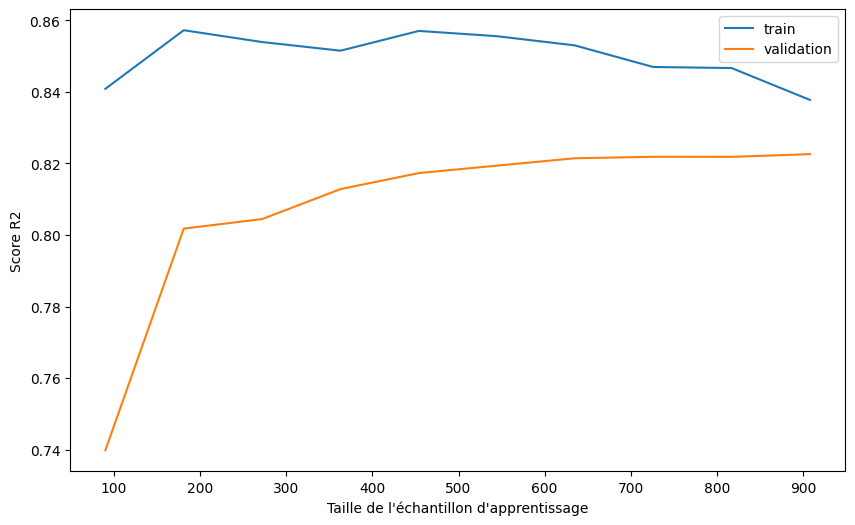

In [9]:


# REGRESSION LASSO CV
my_pipe_lasso = make_pipeline(my_final_pipeline, Lasso(alpha=46.5))  # avant 21.5, 46.5
# Je fit sur les données
my_pipe_lasso.fit(X_train, y_train)
# le score
print(f"regression lasso : {my_pipe_lasso.score(X_test, y_test)}")

# Learning curve
N, train_score, val_score = learning_curve(my_pipe_lasso, X_train, y_train, 
                                           train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('Taille de l\'échantillon d\'apprentissage')
plt.ylabel('Score R2')
plt.legend()
plt.show()




import pickle 
# Sauvegarde du modèle en fichier .pkl
with open('modele.pkl', 'wb') as file:
    pickle.dump(my_pipe_lasso, file)



In [10]:
# REGRESSION LINEAIRE
import statsmodels.api as sm

# Appliquer le prétraitement sur X_train
X_train_preprocessed = preprocessing.fit_transform(X_train)

# Ajouter une colonne de constante
X_train_preprocessed = sm.add_constant(X_train_preprocessed)

# Modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_preprocessed).fit()

#create instance of influence
influence = model.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance[0]

#display Cook's distances
print(cooks)


[7.48947050e-05 2.11590767e-03 1.41915689e-05 ... 1.74703994e-04
 5.35261556e-06 5.92627838e-05]


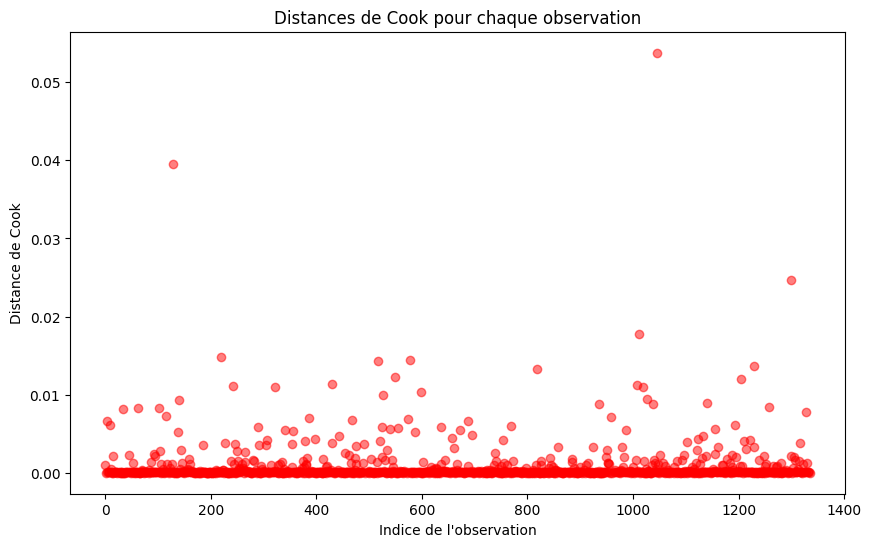

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Afficher les distances de Cook graphiquement
plt.figure(figsize=(10, 6))
plt.scatter(X_train.index, cooks, c='red', marker='o', alpha=0.5)
plt.title("Distances de Cook pour chaque observation")
plt.xlabel("Indice de l'observation")
plt.ylabel("Distance de Cook")
plt.show()

### Lasso

In [12]:
my_pipe_lasso[-1].coef_

array([   0.        ,    0.        ,   -0.        ,    0.        ,
          0.        ,    0.        ,   -0.        ,    0.        ,
        683.44645102,   -0.        ,    0.        ,  430.7033671 ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,  264.47796976,
         -0.        ,  108.2054059 ,    9.05309705,   -0.        ,
         -0.        ,    0.        ,    0.        ,  -18.3463864 ,
         -0.        ,   -0.        ,   -0.        ,   -0.        ,
         -0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,   -0.        ,    0.        ,   -0.        ,
       1055.15644831,    0.        ,    0.        ,    0.        ,
          0.        ,   -0.        ,  495.74150704,   -0.        ,
        260.55148651,   54.36025845,    0.        ,    0.        ,
        294.57474894,   -0.        ,    0.        ,   -0.        ,
        -19.79825974,   -0.        ,   -0.        ,   -0.     

In [ ]:
with open('modele.pkl', 'rb') as file:
    model = pickle.load(file)
    prediction = model.predict(dicc_test)
    # st.markdown(f"<span style='color:green; font-size:54px;'>**{round(prediction[0], 4)} $**</span>", unsafe_allow_html=True)
    print(prediction)

[3313.35318792]


In [ ]:
# Faire une prédiction sur de nouvelles données
y_pred = my_pipe_lasso.predict(X_test)

# X_new doit être un tableau ou une liste contenant les
# caractéristiques des nouvelles données sur lesquelles vous voulez faire des prédictions.

# Afficher les prédictions
print("Prédictions :", y_pred)

Prédictions : [ 2896.32542862 34615.24959518  6817.58395152 40315.67969076
 29870.85040697  6720.09221397  3920.56053489  3644.48065378
  2782.88365986 39287.29341243 10168.28544795 12367.3112207
  3172.03368701 16151.85076511  2814.57700023  2718.44292897
  2467.80300895  6750.45332908  3655.5835854  22921.22634191
 13835.03344543  9925.15791707 13151.1141922  14476.20955182
  6046.71800933  3058.73985782 12452.9917033  10915.84098141
  3194.16053452  3398.50563005  4129.04162918 12793.16082764
 10837.40087924 21821.09878521 29885.02967513 47390.62440313
  3693.04014016 13140.07974901 18111.32571552 11237.40734726
  6327.89198618  5730.48865137 28415.77025998 16584.24023996
 30856.0317457   3786.29921779 11415.71825654 12043.51348306
 42955.32674092 11219.77997096  4827.79414133 39269.04557891
 15303.98823325 13663.99559415  3183.71702697 15706.18875107
  7423.87284335  9846.03473055  9380.13318758  5196.71540198
  4345.23703775 39700.94328556 12779.60810035  9998.92660314
 15637.8935

In [ ]:
#from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
print(f"r2 : {r2}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"rmse : {rmse}")

r2 : 0.90345728576361
rmse : 3740.3961785003735


In [ ]:
# R²

# R² mesure la proportion de la variance de la variable dépendante
# (la variable que vous essayez de prédire) qui est expliquée par le modèle.
# Une valeur de R² proche de 1.0 indique un bon ajustement du modèle aux données,
# signifiant que le modèle explique une grande partie de la variabilité de la variable dépendante.
# Dans notre cas, un R² de 0.904 suggère que votre modèle explique environ 90.4%
# de la variance dans les données de test. C'est généralement considéré comme un bon ajustement.

# RMSE

# RMSE mesure l'écart moyen entre les valeurs réelles et les valeurs prédites par le modèle.
# Il est exprimé dans les mêmes unités que la variable dépendante.
# Une valeur de RMSE plus basse indique une meilleure performance du modèle.
# Dans notre cas, un RMSE de 3730.38 indique que, en moyenne, les prédictions de notre modèle
# ont une erreur d'environ 3730.38 unités par rapport aux valeurs réelles.


# Conclusion

# En résumé, avec un R² élevé et un RMSE relativement bas,
# il semble que votre modèle de régression linéaire performe bien sur les données de test.
# Cependant, il est toujours recommandé de compléter ces scores avec
# une analyse visuelle des résidus et d'autres métriques d'évaluation,
# en fonction du contexte spécifique de votre problème.

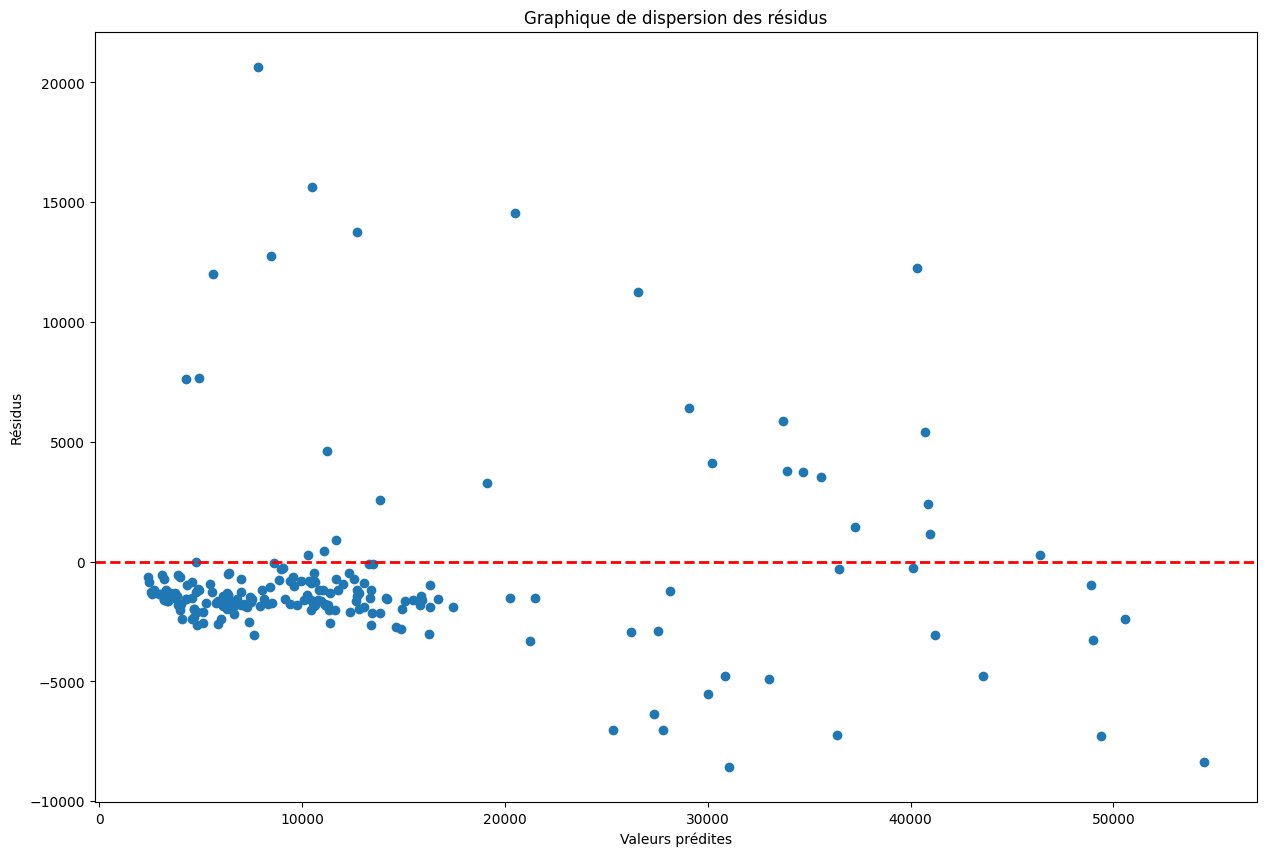

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Faire des prédictions sur les données de test
y_pred = my_pipe_lr.predict(X_test)

# Calculer les résidus
residuals = y_test - y_pred

# Tracer le graphique de dispersion entre les valeurs prédites et les résidus
plt.figure(figsize=(15,10))
plt.scatter(y_pred, residuals)
#sns.scatterplot(y_pred)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Ajouter une ligne horizontale à y=0 pour référence
plt.title('Graphique de dispersion des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
param = {"lasso__alpha" : np.arange(0.5,50, 0.5)}

grid = GridSearchCV(my_pipe_lasso, param, cv=5)
grid.fit(X_train, y_train)

/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+10, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+10, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/sit

/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e+10, tolerance: 1.381e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.511e+09, tolerance: 1.271e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/sit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['...
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. ,
       33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5,
       39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. ,
       44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5])})

In [ ]:
grid.best_params_

{'lasso__alpha': 6.0}

### Ridge

In [ ]:
# REGRESSION RIDGE CV 
my_pipe_ridge = make_pipeline(my_final_pipeline, Ridge(alpha=1e-05))
# Je fit sur les données
my_pipe_ridge.fit(X_train, y_train)
# le score
print(f"regression ridge : {my_pipe_ridge.score(X_test, y_test)}")

regression ridge : 0.8992739862644407


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {"ridge__alpha" : np.arange(0.00001, 0.0001, 0.05)}

grid = GridSearchCV(my_pipe_ridge, param, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['sex',
                                                                          'region'])])),
                                       ('ridge', Ridge(alpha=1e-05))]),
             param_grid={'ridge__alpha': array([1.e-05])})

In [ ]:
grid.best_params_

{'ridge__alpha': 1e-05}

### ElasticNet

In [ ]:
# REGRESSION ELASTICNETCV
my_pipe_elasticnet = make_pipeline(my_final_pipeline, ElasticNet(alpha=9.1e-05)) # avant alpha = 0.01
# Je fit sur les données
my_pipe_elasticnet.fit(X_train, y_train)
# le score
print(f"regression elasticnet : {my_pipe_elasticnet.score(X_test, y_test)}")

# si l1_ratio = 1 alors elasticnet devient un lasso
# si l1_ratio = 0 alors elasticnet devient un ridge

regression elasticnet : 0.9079316829162473


/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+10, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {"elasticnet__alpha" : np.arange(0.000001, 0.0001, 0.00001),
         "elasticnet__l1_ratio" : np.arange(0.001, 1, 0.1)}

grid = GridSearchCV(my_pipe_elasticnet, param, cv=5)
grid.fit(X_train, y_train)

# np.arange(0.000001, 0.0001, 0.1)

/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+10, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e+10, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/sit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['sex',
                                                                          'region'])])),
                                       ('elasticnet',
                                        ElasticNet(alpha=9.1e-05))]),
             param_grid={'elasticnet__alpha': array([1.0e-06, 1.1e-05, 2.1e-05, 3.1e-05, 4.1e-05, 5.1e-05, 6.1e-05,
       7.1e-05, 8.1e-05, 9.1e-05]),
                         'elasticnet__l1_ratio': array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901])})

In [ ]:
grid.best_params_

{'elasticnet__alpha': 9.1e-05, 'elasticnet__l1_ratio': 0.001}